In [1]:
from astropy.table import Table, Column
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm

sys.path.insert(0, '../Modules')
import erqScaling
import erqMedSpec
import os

In [2]:
# Reading data
smp=Table.read('../LumMatch/LumMatch.fits')


iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
# rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
rw3_0=smp['r-w3']
rz_0=smp['r-z']
iz_0 = iW3_0 - rw3_0 + rz_0
Lum_0 = smp['Lum']
z_dr12 = smp['z_dr12']
plate = smp['Plate']
mjd = smp['MJD']
fiber =  smp['FiberID']
X_0=np.array(list(zip(iW3_0, rew_0)))
# (X_scaled, mean_X, std_X) = scale(X_0)
# X, m, r =erqScaling.MinMaxScaler(X_0)
X = X_0
x_erq =  4.6  #(4.6-np.min(iW3_0))/(np.max(iW3_0)-np.min(iW3_0))
y_erq = 2  #(2- np.min(rew_0))/(np.max(rew_0)-np.min(rew_0))
Main_center = np.median(X, axis=0)
ERQ= X[(iW3_0>=x_erq) & (rew_0>=y_erq)]

print(Main_center)

[ 2.48684618 35.92048642]


In [3]:
enclosing_ratio=0.85
bw=3 # bandwidth ratio for the default value
resolution=100
coeff=0.9
dir = 'outData/%.2f/bw-%.2f/enc-r-%.2f' %(coeff, bw, enclosing_ratio)
if os.path.exists(dir)==False:
    os.system('mkdir -p ' + dir)
# os.chdir(dir)
ERQ_vector = np.median(ERQ, axis=0) - np.median(X, axis=0)
ERQ_direction = erqMedSpec.modified_arctan(ERQ_vector[0], ERQ_vector[1])
edge = []
opening_angle= np.deg2rad(8.5)
# print(ERQ_direction)
cen= np.median(X_0,axis=0)
A = [8.01429, 2.27435]
lA = np.linalg.norm(A-cen)
dirA =  erqMedSpec.modified_arctan(A[0], A[1])
# A[0] = cen[0] + lA*np.cos(dirA)
# A[1] = cen[1] +lA*np.sin(dirA)
B=[0,0]
B[0] = cen[0]+ lA*np.cos(ERQ_direction+opening_angle*0.5)
B[1] = cen[1] + lA*np.sin(ERQ_direction+opening_angle*0.5)
print(cen, lA)

[ 2.48684618 35.92048642] 34.09714256640507


In [41]:
%matplotlib
ngrids=100
levels =  coeff*np.array([ 1/32, 1/8, 1/3])
wdg=200
A2 = 2* cen -A
B2= 2*cen - B

A1 = B
B1 = [5,2.8]

A3 = [7.96, 0.43]
B3 = [8.29171,1.80195]

A4 = B3
B4 = A 


ymax,ymin = np.max(rew_0), np.min(rew_0)
xmax, xmin = np.max(iW3_0), np.min(iW3_0)
Ar1 = [cen[0]-1.5,ymax]
Br1 = [cen[0]+1.5,ymax]
Ar2 = [cen[0]-1.5,ymin]
Br2 = [cen[0]+1.5,ymin]

Ai1 = [xmax, cen[1]+0.5]
Bi1 = [xmax, cen[1] -0.5]

Ai2 = [xmin, cen[1]+0.5]
Bi2 = [xmin, cen[1] -0.5]
wedge_direction = ERQ_direction

print('wedge-direction=', wedge_direction, 'ratio=', enclosing_ratio)
# for wdg, Ax, Bx in [[0, A, B], [1, A1, B1], [2, A2,B2], [3, A3,B3], [4, A4,B4], [10, Ar1, Br1], [20, Ar2, Br2], [100, Ai1, Bi1], [200,Ai2,Bi2]]:
for wdg, Ax, Bx in [[4, A4,B4]]:
    
    bin_label, bin_pop, tip_label = erqMedSpec.KDE_Bin2D(X, x_erq, y_erq,\
                                              ngrids,  bw, levels, \
                                              Ax, Bx, \
                                              x_erq, y_erq,\
                                              True,[1.4,  1.7, 2.2],\
                                              dir+'/Bins-ratio-%.2f-bw-%.2f-wdg-%1d.png'\
                                              %(enclosing_ratio, bw, wdg), \
                                              True, 'i-w3','log10(rew)', \
                                              'enc_ratio=%.2f' %(enclosing_ratio))
    np.savetxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt', bin_label)
    np.savetxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt', bin_pop)

Using matplotlib backend: Qt5Agg
wedge-direction= 0.20810135506420965 ratio= 0.85
KDE density estimation in 2D...
Contour plot...


../Modules/erqMedSpec.py:405: UserWarning: The following kwargs were not used by contour: 'c'
  c = ax.contour(xi, yi, zi.reshape(xi.shape), levels=levels, alpha=0.6, c='black')
  1%|▏         | 414/30592 [00:00<00:14, 2023.56it/s]

hull...


100%|██████████| 7/7 [00:00<00:00, 87.74it/s]


plotting
tip_pop 22815


In [44]:
#  Med-Spec
tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
mask = (tip_label==1)
tipSpec = erqMedSpec.stacker(z_dr12[mask], plate[mask], mjd[mask], fiber[mask]) 

# for wdg in [0,1,2,3,4, 10, 20, 100, 200]:
for wdg in [4]:

    bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
    bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')

    nBin = 7
    for b in range(1,nBin+1):
        if(b==1):
            medSpec = tipSpec
            np.savetxt(dir+'/med-spec-bw-%.2f-wdg-%d-bin-%d.txt' %(bw, wdg, b), medSpec)
        else:
            mask = (bin_label==b)
            medSpec = erqMedSpec.stacker(z_dr12[mask], plate[mask], mjd[mask], fiber[mask])
            np.savetxt(dir +'/med-spec-bw-%.2f-wdg-%d-bin-%d.txt' %(bw, wdg, b), medSpec)


100%|██████████| 22815/22815 [31:25<00:00, 12.10it/s]
/home/reza/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
100%|██████████| 266/266 [00:21<00:00, 12.16it/s]
/home/reza/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
100%|██████████| 6/6 [00:00<00:00, 10.89it/s]


In [64]:
#  Table for eah wedge
for wdg in [0,1,2,3,4, 10, 20, 100, 200]:
    bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
    bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')
    tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
    tip_pop= np.sum(tip_label)
    
    #  Median properties in each bin


    imw3_bin_med =[]
    REW_bin_med = []
    fwhm_bin_med = []
    kt80_bin_med = []
    frat_bin_med = []
    iz_bin_med = []
    Lum_bin_med = []
    BinPop=[]
    for b in range(1,nBin+1):
        if(b>1):
            mask = (bin_label==b)
            BinPop.append(bin_pop[b-1])

        else:
            mask = (tip_label==1)
            BinPop.append(tip_pop)


        imw3_bin_med.append(np.median(iW3_0[mask]))
        REW_bin_med.append(np.median(rew_0[mask]))
        fwhm_bin_med.append(np.median(fwhm_0[mask]))
        kt80_bin_med.append(np.median(kt80_0[mask]))
        frat_bin_med.append(np.median(frat_0[mask]))
        iz_bin_med.append(np.median(iz_0[mask]))
        Lum_bin_med.append(np.median(Lum_0[mask]))

    tabProperties = Table([BinPop, imw3_bin_med, REW_bin_med, fwhm_bin_med, kt80_bin_med, frat_bin_med, iz_bin_med, Lum_bin_med],
                          names=('nBin', 'iw3', 'rew', 'fwhm', 'kt80', 'frat', 'iz', 'Lum'))
    if os.path.exists(dir+ '/wdg-%d-Properties.fits' %(wdg)):
        os.system('rm '+ dir+'/wdg-%d-Properties.fits' %(wdg))
    tabProperties.write(dir+ '/wdg-%d-Properties.fits' %(wdg), format='fits')

In [76]:
#  on table for all wedges
imw3_bin_med =[]
REW_bin_med = []
fwhm_bin_med = []
kt80_bin_med = []
frat_bin_med = []
iz_bin_med = []
Lum_bin_med = []
BinPop=[]
Wedge=[]
binNo=[]
for wdg in [0,1,2,3,4, 10, 20, 100, 200]:
    bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
    bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')
    tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
    tip_pop= np.sum(tip_label)
    from line_db import line_db
    from matplotlib import cm
    from scipy import ndimage

    
    #  Median properties in each bin


    
    for b in range(1,nBin+1):
        if(b>1):
            mask = (bin_label==b)
            BinPop.append("{0:.0f}".format(bin_pop[b-1]))

        else:
            mask = (tip_label==1)
            BinPop.append("{0:.0f}".format(tip_pop))

        
        imw3_bin_med.append("{0:.2f}".format(np.median(iW3_0[mask])))
        REW_bin_med.append("{0:.0f}".format(np.median(rew_0[mask])))
        fwhm_bin_med.append("{0:.0f}".format(np.median(fwhm_0[mask])))
        kt80_bin_med.append("{0:.2f}".format(np.median(kt80_0[mask])))
        frat_bin_med.append("{0:.2f}".format(np.median(frat_0[mask])))
        iz_bin_med.append("{0:.2f}".format(np.median(iz_0[mask])))
        Lum_bin_med.append("{0:.2f}".format(np.median(Lum_0[mask])))
        Wedge.append("{0:.0f}".format(wdg))
        binNo.append("{0:.0f}".format(b))
tabProperties = Table([Wedge, binNo, BinPop, imw3_bin_med, REW_bin_med, fwhm_bin_med, kt80_bin_med, frat_bin_med, iz_bin_med, Lum_bin_med],
                      names=('Wedge','nBin', 'BinPop', 'iw3', 'rew', 'fwhm', 'kt80', 'frat', 'iz', 'Lum'))
if os.path.exists(dir+ '/All-Wedge-Properties.fits' ):
    os.system('rm '+ dir+'/All-Wedge-Properties.fits' )
tabProperties.write(dir+ '/All-Wedge-Properties.fits' , format='fits')

In [46]:
for wdg in [0,1,2,3,4, 10, 20, 100, 200]:
# for wdg in [4]:
    bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
    bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')
    tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
    tip_pop= np.sum(tip_label)
    from line_db import line_db
    from matplotlib import cm
    from scipy import ndimage

    # c = cm.get_cmap('coolwarm', 7)
    c=['gray', 'red', 'green','blue', 'darkred', 'C4', 'black' ]
    ymax=20.5
    ymin=0.02*ymax
    fs=8
    fs1=7
    y_median = 0.95*ymax
    med_step=.8
    legend_loc=7

    # -----------
    step = 1.00015
    bb = np.arange(0,8813,1)
    wgrid = 800.0 * step**bb
    nw = len(bb)
    for ii in range(4):

        if(ii==0): lambda_min = 1000; lambda_max = 1980
        if(ii==1): lambda_min = 1150; lambda_max = 1980
        if(ii==2): lambda_min = 1150; lambda_max = 2850
        if(ii==3): lambda_min = 1150; lambda_max = 1700
        fig = plt.figure(figsize=(11.5,5.6))

        plt.xlim(lambda_min,lambda_max)
        plt.ylim(ymin, ymax)
        x_median=lambda_min+200

        for b in range(1,nBin+1):
    #     for b in range(len(bin_pop)):
            if(bin_pop[b-1]>=5):   
                print('bin:', b, lambda_min, 'to', lambda_max)
                medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
                plt.ylabel('Normalized Flux')
                plt.xlabel(r'$\lambda  (\AA)$')


                if(bin_pop[b-1]<100):
                    SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                else:
                    SmoothedMedSpec = medSpec

                # masking for plot ranges
                ind = (wgrid>lambda_min) & (wgrid<lambda_max)
                if(b>1):
                    plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = .5, c=c[b-1], 
                             label='bin-%d #%d' %(b, bin_pop[b-1]))
                else:

                    plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = 3, c=c[b-1], 
                             label='bin-%d #%d' %(b, tip_pop), alpha=0.5)



        plt.legend(loc=7)
        plt.title('Wedge: %d' %wdg)
        line_db( ymax, fs, fs1, ii) 
        fig_path = dir + '/med-spec-%d-%d-wdg-%d.png'%(lambda_min, lambda_max, wdg)

        plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
        plt.show()

bin: 1 1000 to 1980
bin: 2 1000 to 1980
bin: 3 1000 to 1980
bin: 4 1000 to 1980
bin: 5 1000 to 1980
bin: 6 1000 to 1980
bin: 7 1000 to 1980
bin: 1 1150 to 1980
bin: 2 1150 to 1980
bin: 3 1150 to 1980
bin: 4 1150 to 1980
bin: 5 1150 to 1980
bin: 6 1150 to 1980
bin: 7 1150 to 1980
bin: 1 1150 to 2850
bin: 2 1150 to 2850
bin: 3 1150 to 2850
bin: 4 1150 to 2850
bin: 5 1150 to 2850
bin: 6 1150 to 2850
bin: 7 1150 to 2850
bin: 1 1150 to 1700
bin: 2 1150 to 1700
bin: 3 1150 to 1700
bin: 4 1150 to 1700
bin: 5 1150 to 1700
bin: 6 1150 to 1700
bin: 7 1150 to 1700


bin: 1 1000 to 1980
bin: 7 1000 to 1980


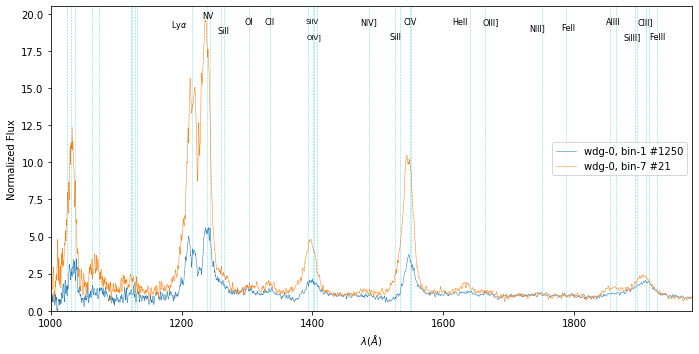

bin: 1 1150 to 1980
bin: 7 1150 to 1980


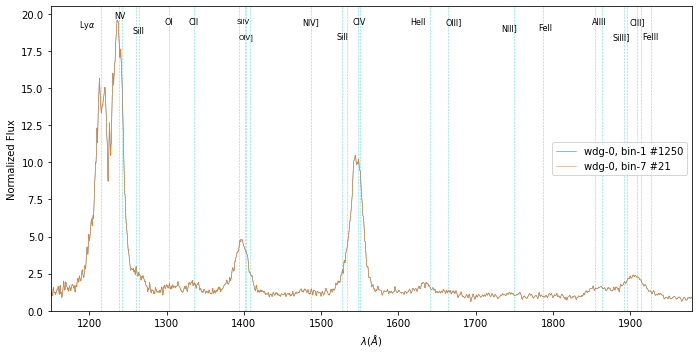

bin: 1 1150 to 2850
bin: 7 1150 to 2850


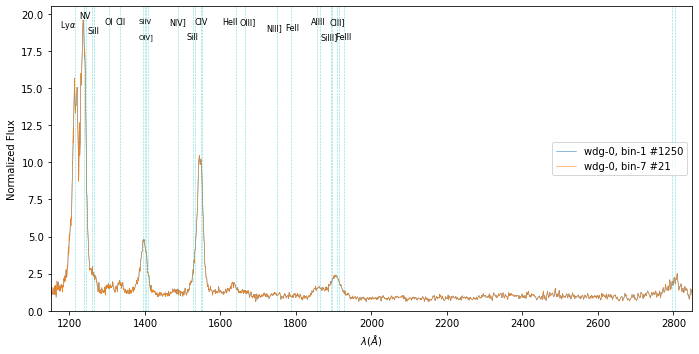

bin: 1 1150 to 1700
bin: 7 1150 to 1700


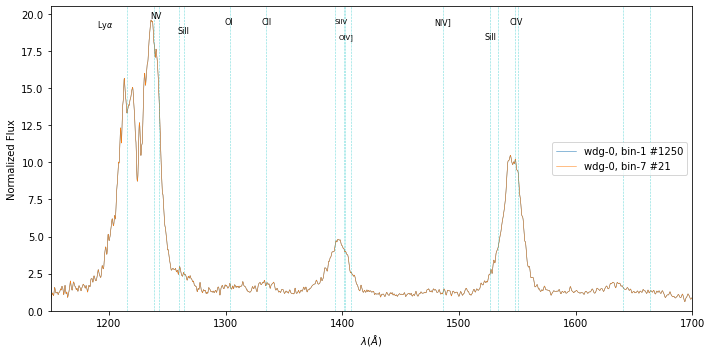

In [7]:
#  PLotting  all bin-5  for wedges clos to erq wedge

tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
tip_pop= np.sum(tip_label)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage
c=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
ymax=20.5
ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7
   # -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nBin=7
for ii in range(4):
    ci=-1
    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))

    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0,1,3,4]:
        bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
        bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')

        

        for b in range(5,6):
    #     for b in range(len(bin_pop)):
            if(bin_pop[b-1]>=4):   
                ci+=1
                print('bin:', b, lambda_min, 'to', lambda_max)
                medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
               

                if(bin_pop[b-1]<100):
                    SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                
                # masking for plot ranges
                ind = (wgrid>lambda_min) & (wgrid<lambda_max)
                plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = .5, c=c[ci], 
                             label='wdg-%d, bin-%d #%d' %(wdg, b,  bin_pop[b-1]))
                

    plt.legend(loc=7)
    plt.ylabel('Normalized Flux')
    plt.xlabel(r'$\lambda  (\AA)$')

    line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/med-spec-%d-%d-wdg-out-bin-5.png'%(lambda_min, lambda_max)

    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


bin: 6 1000 to 1980
bin: 6 1000 to 1980
bin: 6 1000 to 1980
bin: 6 1000 to 1980


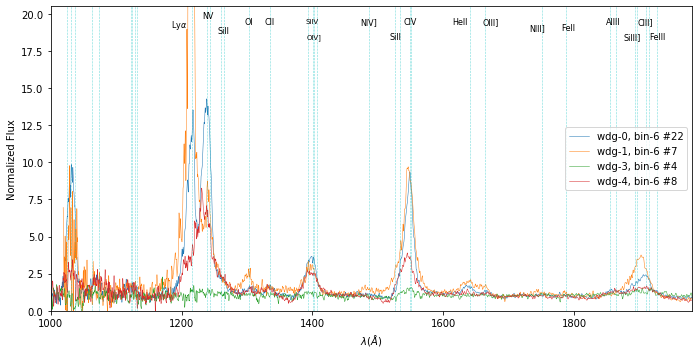

bin: 6 1150 to 1980
bin: 6 1150 to 1980
bin: 6 1150 to 1980
bin: 6 1150 to 1980


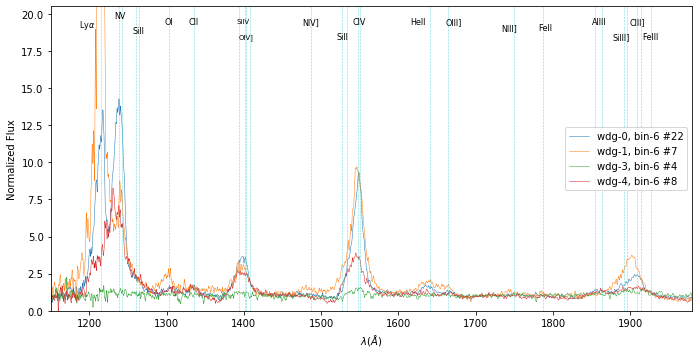

bin: 6 1150 to 2850
bin: 6 1150 to 2850
bin: 6 1150 to 2850
bin: 6 1150 to 2850


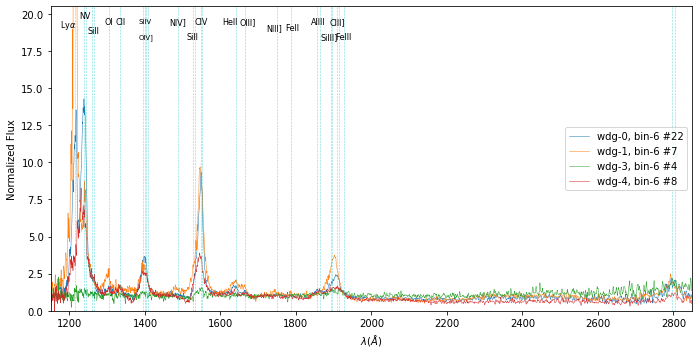

bin: 6 1150 to 1700
bin: 6 1150 to 1700
bin: 6 1150 to 1700
bin: 6 1150 to 1700


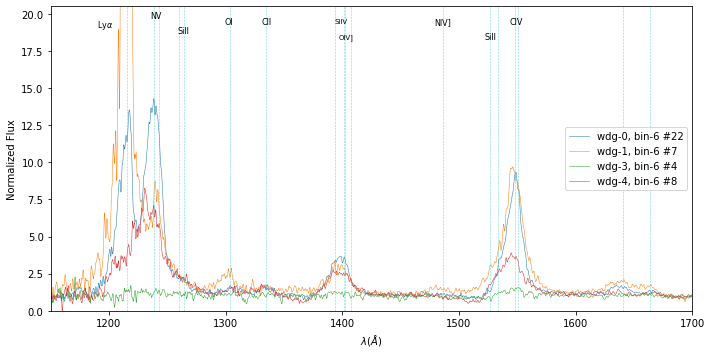

In [6]:
#  PLotting  all bin-6  for wedges clos to erq wedge

tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
tip_pop= np.sum(tip_label)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage
c=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
ymax=20.5
ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7
   # -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nBin=7
for ii in range(4):
    ci=-1
    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))

    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0,1,3,4]:
        bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
        bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')

        

        for b in range(6,nBin):
    #     for b in range(len(bin_pop)):
            if(bin_pop[b-1]>=4):   
                ci+=1
                print('bin:', b, lambda_min, 'to', lambda_max)
                medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
               

                if(bin_pop[b-1]<100):
                    SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                
                # masking for plot ranges
                ind = (wgrid>lambda_min) & (wgrid<lambda_max)
                plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = .5, c=c[ci], 
                             label='wdg-%d, bin-%d #%d' %(wdg, b,  bin_pop[b-1]))
                

    plt.legend(loc=7)
    plt.ylabel('Normalized Flux')
    plt.xlabel(r'$\lambda  (\AA)$')

    line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/med-spec-%d-%d-wdg-out-bin-6.png'%(lambda_min, lambda_max)

    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


bin: 7 1000 to 1980
bin: 7 1000 to 1980
bin: 7 1000 to 1980


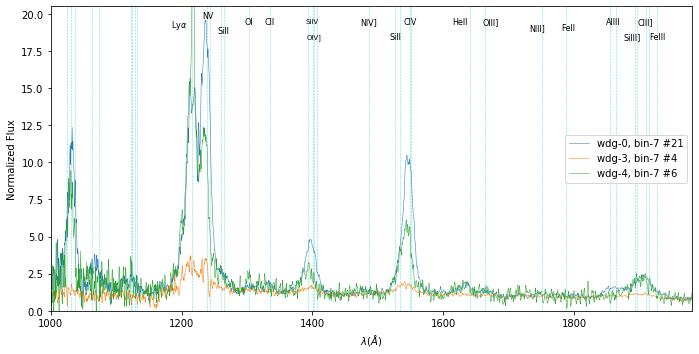

bin: 7 1150 to 1980
bin: 7 1150 to 1980
bin: 7 1150 to 1980


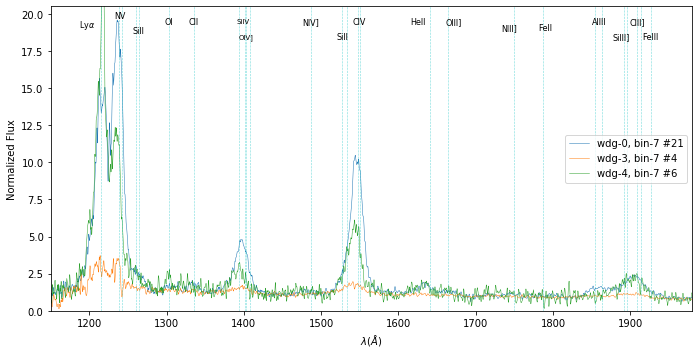

bin: 7 1150 to 2850
bin: 7 1150 to 2850
bin: 7 1150 to 2850


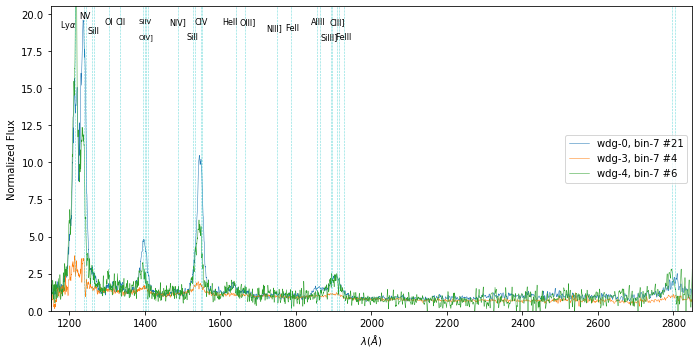

bin: 7 1150 to 1700
bin: 7 1150 to 1700
bin: 7 1150 to 1700


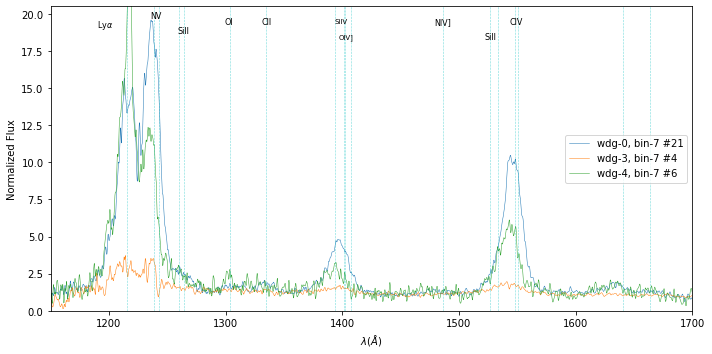

In [7]:
#  PLotting  all bin-7  for wedges clos to erq wedge

tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
tip_pop= np.sum(tip_label)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage
c=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
ymax=20.5
ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7
   # -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nBin=7
for ii in range(4):
    ci=-1
    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))

    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0,1,3,4]:
        bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
        bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')

        

        for b in range(nBin, nBin+1):
    #     for b in range(len(bin_pop)):
            if(bin_pop[b-1]>=4):   
                ci+=1
                print('bin:', b, lambda_min, 'to', lambda_max)
                medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
               

                if(bin_pop[b-1]<100):
                    SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                
                # masking for plot ranges
                ind = (wgrid>lambda_min) & (wgrid<lambda_max)
                plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = .5, c=c[ci], 
                             label='wdg-%d, bin-%d #%d' %(wdg, b,  bin_pop[b-1]))
                

    plt.legend(loc=7)
    plt.ylabel('Normalized Flux')
    plt.xlabel(r'$\lambda  (\AA)$')

    line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/med-spec-%d-%d-wdg-out-bin-7.png'%(lambda_min, lambda_max)

    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


bin: 1 1000 to 1980
bin: 2 1000 to 1980
bin: 3 1000 to 1980
bin: 4 1000 to 1980
bin: 5 1000 to 1980
bin: 6 1000 to 1980
bin: 7 1000 to 1980
bin: 1 1000 to 1980
bin: 2 1000 to 1980
bin: 3 1000 to 1980
bin: 4 1000 to 1980
bin: 5 1000 to 1980
bin: 6 1000 to 1980
bin: 7 1000 to 1980


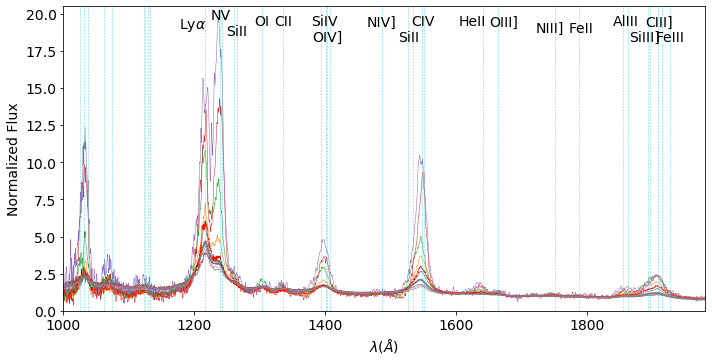

bin: 1 1150 to 1980
bin: 2 1150 to 1980
bin: 3 1150 to 1980
bin: 4 1150 to 1980
bin: 5 1150 to 1980
bin: 6 1150 to 1980
bin: 7 1150 to 1980
bin: 1 1150 to 1980
bin: 2 1150 to 1980
bin: 3 1150 to 1980
bin: 4 1150 to 1980
bin: 5 1150 to 1980
bin: 6 1150 to 1980
bin: 7 1150 to 1980


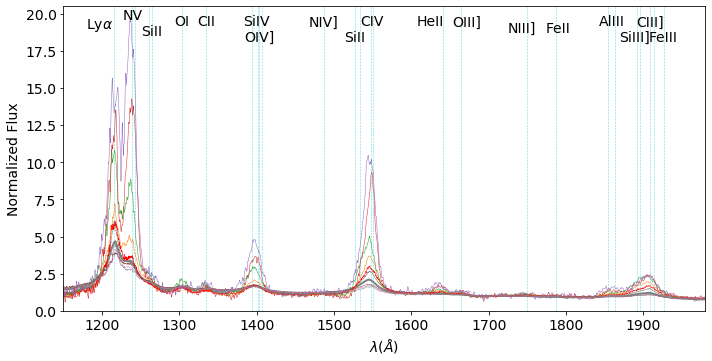

bin: 1 1150 to 2850
bin: 2 1150 to 2850
bin: 3 1150 to 2850
bin: 4 1150 to 2850
bin: 5 1150 to 2850
bin: 6 1150 to 2850
bin: 7 1150 to 2850
bin: 1 1150 to 2850
bin: 2 1150 to 2850
bin: 3 1150 to 2850
bin: 4 1150 to 2850
bin: 5 1150 to 2850
bin: 6 1150 to 2850
bin: 7 1150 to 2850


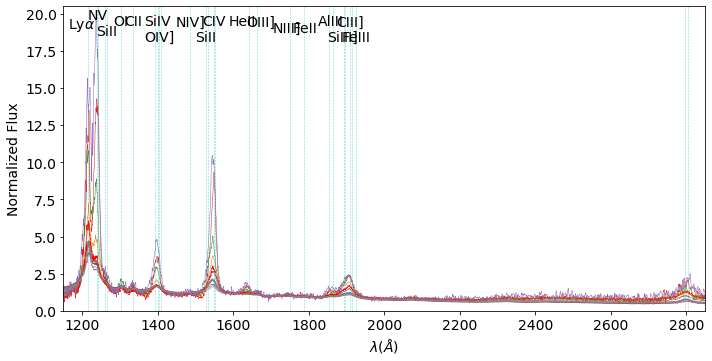

bin: 1 1150 to 1700
bin: 2 1150 to 1700
bin: 3 1150 to 1700
bin: 4 1150 to 1700
bin: 5 1150 to 1700
bin: 6 1150 to 1700
bin: 7 1150 to 1700
bin: 1 1150 to 1700
bin: 2 1150 to 1700
bin: 3 1150 to 1700
bin: 4 1150 to 1700
bin: 5 1150 to 1700
bin: 6 1150 to 1700
bin: 7 1150 to 1700


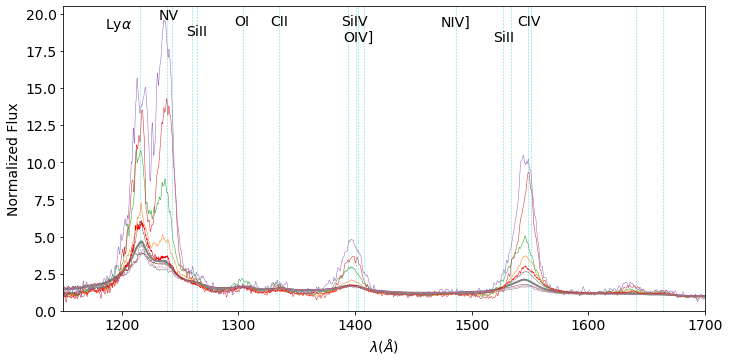

In [8]:
#  PLotting  wedge 0 and 2 in one plot 

tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
tip_pop= np.sum(tip_label)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage
c=['gray', 'red', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'black']
ymax=20.5
ymin=0.02*ymax
fs=14
fs1=fs
y_median = 0.95*ymax
med_step=.8
legend_loc=7
   # -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nBin=7
for ii in range(4):
    ci=-1
    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))
    # masking for plot ranges
    ind = (wgrid>lambda_min) & (wgrid<lambda_max)
    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0,2]:
        bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
        bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')
        
        for b in range(1,nBin+1):
            
            print('bin:', b, lambda_min, 'to', lambda_max)
            medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
            if(b>1):
                if(bin_pop[b-1]>=5):
                    ci+=1
                    if(bin_pop[b-1]<100):
                        SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                        
                    else:
                        SmoothedMedSpec=medSpec
                        
                    plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = .5, c=c[ci], 
                                 label='wdg-%d, bin-%d #%d' %(wdg, b,  bin_pop[b-1]))
            else:
                if(wdg==0):
                    plt.plot(wgrid[ind],  medSpec[ind], lw =2, c='gray', 
                                     label='wdg-%d, bin-%d #%d' %(wdg, b,  tip_pop))

            
    # plt.legend(loc=7)
    plt.ylabel('Normalized Flux', fontsize=fs)
    plt.xlabel(r'$\lambda  (\AA)$', fontsize=fs)
    line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/med-spec-%d-%d-wdg-0+2.png'%(lambda_min, lambda_max)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


In [12]:
dir


'outData/0.90/bw-3.00/enc-r-0.85'

bin: 1 1470 to 1600
bin: 7 1470 to 1600


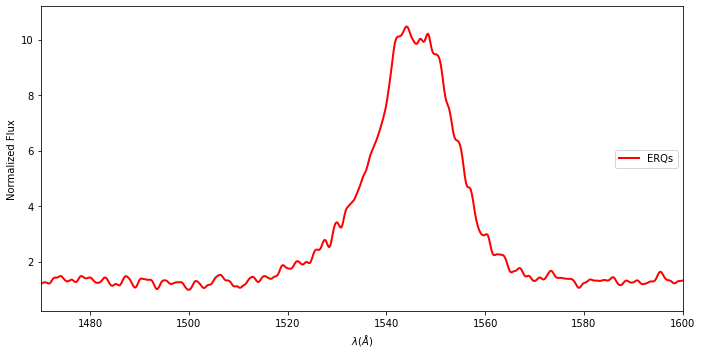

bin: 1 1470 to 1600
bin: 7 1470 to 1600


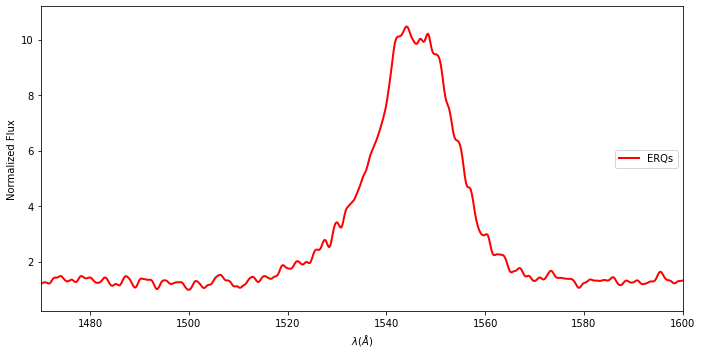

bin: 1 1470 to 1600
bin: 7 1470 to 1600


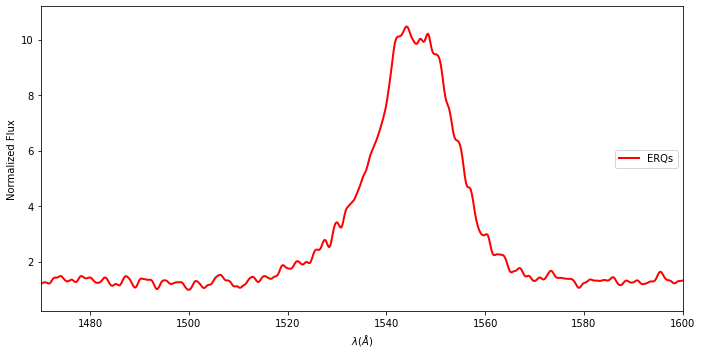

bin: 1 1470 to 1600
bin: 7 1470 to 1600


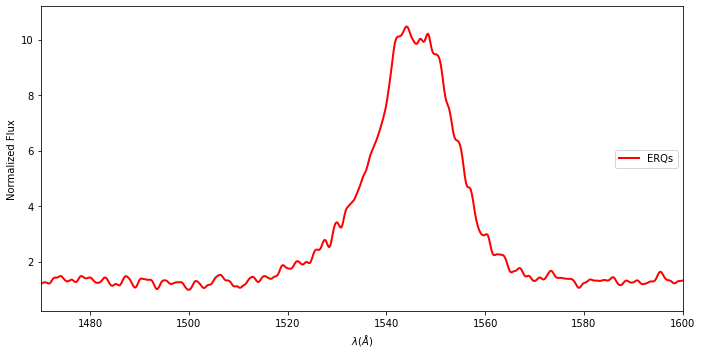

In [25]:
#  PLotting  wedge 0 and 2 in one plot 

tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
tip_pop= np.sum(tip_label)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage
c=['red', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'black']
ymax=11.2
ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7
   # -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nBin=7
for ii in range(4):
    ci=-1
    if(ii==0): lambda_min = 1470; lambda_max = 1600
#     if(ii==1): lambda_min = 1150; lambda_max = 1980
#     if(ii==2): lambda_min = 1150; lambda_max = 2850
#     if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))
    # masking for plot ranges
    ind = (wgrid>lambda_min) & (wgrid<lambda_max)
    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0]:
        bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
        bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')
        
        for b in [1,nBin]:
            
            print('bin:', b, lambda_min, 'to', lambda_max)
            medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
            if(b>1):
                if(bin_pop[b-1]>=5):
                    ci+=1
                    if(bin_pop[b-1]<100):
                        SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                        
                    else:
                        SmoothedMedSpec=medSpec
                        
                    plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = 2, c=c[ci], 
                                 label='ERQs')
#             else:
#                 if(wdg==0):
#                     plt.plot(wgrid[ind],  medSpec[ind], lw =2, c='gray', 
#                                      label='Typical QSO')

            
    plt.legend(loc=7)
    plt.ylabel('Normalized Flux')
    plt.xlabel(r'$\lambda  (\AA)$')

#     line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/c4.png'

    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


In [39]:
# making a table for properties of all wedgs/bins
wedge=[]
Bin=[]
Pop=[]
iw3=[]
rew=[]
fwhm=[]
frat=[]
iz=[]
Lum=[]
kt80=[]
for wdg in [0,1,2,3,4, 10, 20, 100, 200]:
    phys = Table.read(dir+'/wdg-%d-Properties.fits' %wdg)
    for b in range(0,nBin):
        wedge.append(wdg)
        Bin.append(b+1)
        Pop.append(phys['nBin'][b])
        iw3.append(phys['iw3'][b])
        rew.append(phys['rew'][b])
        fwhm.append(phys['fwhm'][b])
        frat.append(phys['frat'][b])
        iz.append(phys['iz'][b])
        Lum.append(phys['Lum'][b])
        kt80.append(phys['kt80'][b])
        
TabAll =Table([np.array(wedge, dtype=np.int16), np.array(nBin, dtype=np.int16)] , #iw3, rew, fwhm, kt80, frat, iz, Lum],
         names=['wedge', 'nBin']) #, 'iw3', 'rew', 'fwhm', 'kt80', 'frat', 'iz', 'Lum'))

# TabAll.write('TabAll.fits', format='fits')

TypeError: len() of unsized object

In [16]:
phys = np.array(list(zip(wedge, Bin, Pop, iw3, rew, kt80, fwhm, frat, iz, Lum)))

In [32]:
np.array(Pop, dtype=np.int16)


array([22815,   335,   186,    83,    33,    22,    21, 22815,   256,
         135,    60,    11,     7,     2, 22815,   127,    53,    20,
           0,     0,     0, 22815,   643,   286,   108,    15,     4,
           4, 22815,   266,   130,    43,    12,     8,     6, 22815,
         718,   353,    94,     4,     1,     0, 22815,   480,   302,
         189,    71,    33,     2, 22815,   542,   251,    92,    17,
           5,     6, 22815,   718,   232,    54,     0,     0,     0],
      dtype=int16)